# Poisson Equation

From fenics demo [Poisson equation](https://fenicsproject.org/olddocs/dolfin/1.5.0/python/demo/documented/poisson/python/documentation.html).

We consider the following Poisson equation in two dimension:
$$ -div (\kappa grad (u(x, y))) = f(x, y) \qquad \text{for } \qquad (x,y) \in \Omega := (0,1)\times(0,1)$$
on the unit square $\Omega = (0,1)\times (0,1)$ with the source $f$ given by
$$ f(x, y) = 10 \exp\left(-((x - 0.5)^2 + (y - 0.5)^2) / 0.02\right)$$
and boundary conditions given by
\begin{align}
u(x,y) &= 0 & \qquad \text{ for } \qquad &(x,y) \in \Gamma_{D} := \{0,1\}\times [0,1] \\
\frac{\partial u(x,y)}{\partial n} &= g(x,y) := \sin(5x) & \qquad \text{ for } \qquad &(x,y) \in \Gamma_{N} := [0,1] \times \{0,1\}.
\end{align}
Here, $\kappa$ is the diffusivity constant. 

## Variational formulation
Let $V$ be the suitable function space defined as
\begin{equation}
V = \{u\in H^1(\Omega): u(x,y) = 0 \text{ for } (x,y) \in \Gamma_D\}.
\end{equation}
Variational problem associated to the above PDE reads: find $u\in V$ ($V$ being suitable function space) such that
\begin{equation}
\underbrace{\int_{\Omega} \kappa \nabla u \cdot \nabla v dx}_{=:a(u,v)} = \underbrace{\int_{\Omega} f v dx + \int_{\Gamma_N} g v ds}_{=:l(v)} \qquad \text{for } \qquad v \in V.
\end{equation}
In the above $a(u,v)$ is the bilinear form and $l(v)$ is the linear form in the variational problem. 

## Finite element approximation
Let $V_h$ be the finite element function space. Then the finite element approximation reads: find $u_h \in V_h$ such that
\begin{equation}
a(u_h,v_h) = l(v_h) \qquad \text{for } \qquad v_h \in V_h.
\end{equation}

## Fenics implementation
We first import the dolfin package.

In [1]:
# dolfin includes fenics
import dolfin as dl

# for plotting
import matplotlib.pyplot as plt 

### Create mesh
We create a mesh consisting of 32 x 32 squares with each square divided into two triangles and consider a function space based on the specfied order Lagrange interpolation as follows:

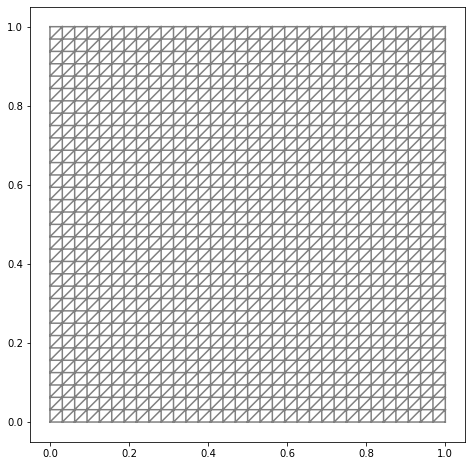

In [2]:
mesh = dl.UnitSquareMesh(32, 32)

# specify order of interpolation
p_order = 2

# create FE function space
V = dl.FunctionSpace(mesh, "Lagrange", p_order) # or dl.FunctionSpace(mesh, "P", p_order)

# plot
plt.figure(figsize=(8,8))
dl.plot(mesh)
plt.show()

### Define boundaries of the domain for boundary conditions

In [3]:
# Define vertical edges (x = 0 or x = 1) for Dirichlet boundary condition
def vert_edges(x):
    return x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS

# Define horizontal edges (x = 0 or x = 1) for Neumann boundary condition
def horiz_edges(x):
    return x[1] < dl.DOLFIN_EPS or x[1] > 1.0 - dl.DOLFIN_EPS

Next, define surface measure for integration of neumann boundary condition over $\Gamma_N$

In [4]:
facets = dl.MeshFunction("size_t", mesh, 1)

# note we use `horiz_edges` in below
dl.AutoSubDomain(horiz_edges).mark(facets, 1)

# create surface measure
ds = dl.Measure("ds", subdomain_data=facets)

Now, create Dirichlet boundary condition object

In [5]:
u_bdr = dl.Constant(0.0) # use dolfin in-built Constant function

# now actually create boundary condition 
# arg1: function space, arg2: value of boundary condition, arg3: boundary domain
u_bc = dl.DirichletBC(V, u_bdr, vert_edges)

Now, create function $g(x,y) = \sin(5x)$ for Neumann boundary condition

In [6]:
# degree specifies interpolation order when interpolating this function on to the mesh
g = dl.Expression("sin(5*x[0])", degree=2)

### Define bilinear and linear forms
First, create variables for test $v$ and trial $u$ functions:

In [7]:
u_trial = dl.TrialFunction(V)
v_test = dl.TestFunction(V)

Now, create function $f$ for right-hand source term:

In [8]:
f = dl.Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)", degree=2)

We are now ready to define bilinear form $a(u,v)$ and linear form $l(v)$:

In [9]:
a = dl.inner(dl.grad(u_trial), dl.grad(v_test))*dl.dx
L = f*v_test*dl.dx + g*v_test*ds

In the above, `dl.grad` is dolfin in-build function for gradient of variable and `dl.dx` is the measure for integral over the domain.

### Solve the problem a(u,v) = l(v)

In [10]:
u = dl.Function(V, name = 'u') # solution variable

# solve using fenics in-build solve function 
# arg1: variational problem, arg2: solution variable, arg3: boundary condition
dl.solve(a == L, u, u_bc)

Solving linear variational problem.


Save solution and plot result

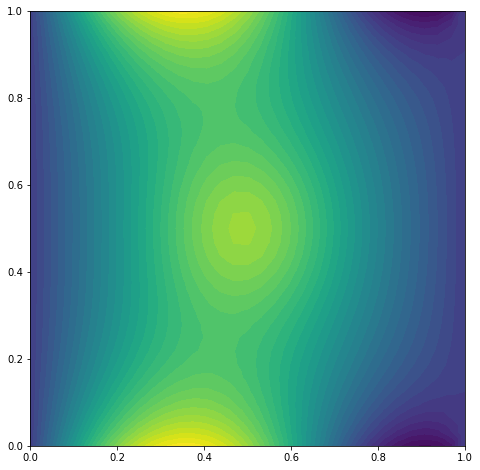

In [11]:
# Save solution in VTK format
file = dl.File("fwd_result/poisson_equation.pvd")
file << u

# Plot solution
plt.figure(figsize=(8,8))
dl.plot(u)
plt.show()

### Plotting in paraview
- load file `poisson_equation.pvd` in paraview
- apply `warp by scalar` filter
- click on `2D` in view panel to change view to `3D`

The result looks as follows

<img src="poisson_equation_result.png" style="width:400px;">

# For further readings
- [Original Fenics demo](https://fenicsproject.org/olddocs/dolfin/2019.1.0/python/demos/poisson/demo_poisson.py.html) that this demo is based on 
- More elaborate explanations and discussion of some other topics such as error, nodal values of solution, etc. in this [Fenics demo](https://fenicsproject.org/pub/tutorial/html/._ftut1004.html)